In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error



## Pre procesamiento


##### 1. Variables Objetivo y Características 
- **Variables objetivo (target)**: predecir el rendimiento por grado por materia,  usando cada una de las calificaciones (Cognitiva, Procedimental, Actitudinal, Axiologica) como variable objetivo.
- **Características (features)**: Las demás columnas se utilizarán como características para predecir la variable objetivo.

##### 2. Tipos de Variables: 
- **Variables categóricas**: Sede, Estudiante, Grado, Grupo, Periodo, Año, Asignatura.
- **Variables numéricas**: Intensidad Horaria, Cognitiva, Procedimental, Actitudinal, Axiologica.

### Agrupar por Grado y Asignatura

In [6]:
calificaciones_to_model_fusa = pd.read_csv("calificaciones_to_model_fusa.csv")
calificaciones_to_model_girardot = pd.read_csv("calificaciones_to_model_girardot.csv")


In [7]:
# Seleccionar solo las columnas numéricas
numerical_columns = ['Intensidad Horaria', 'Cognitiva', 'Procedimental', 'Actitudinal', 'Axiologica','Calificacion_Ponderada']

calificaciones_grouped_fusa = calificaciones_to_model_fusa.groupby(['Grado','Asignatura','Periodo','Año'])[numerical_columns].mean().reset_index()
calificaciones_grouped_girardot = calificaciones_to_model_girardot.groupby(['Grado', 'Asignatura','Periodo','Año'])[numerical_columns].mean().reset_index()


In [8]:
calificaciones_grouped_fusa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Grado                   756 non-null    int64  
 1   Asignatura              756 non-null    object 
 2   Periodo                 756 non-null    object 
 3   Año                     756 non-null    int64  
 4   Intensidad Horaria      756 non-null    float64
 5   Cognitiva               756 non-null    float64
 6   Procedimental           756 non-null    float64
 7   Actitudinal             756 non-null    float64
 8   Axiologica              756 non-null    float64
 9   Calificacion_Ponderada  756 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 59.2+ KB


In [9]:
calificaciones_grouped_girardot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Grado                   528 non-null    int64  
 1   Asignatura              528 non-null    object 
 2   Periodo                 528 non-null    object 
 3   Año                     528 non-null    int64  
 4   Intensidad Horaria      528 non-null    float64
 5   Cognitiva               528 non-null    float64
 6   Procedimental           528 non-null    float64
 7   Actitudinal             528 non-null    float64
 8   Axiologica              528 non-null    float64
 9   Calificacion_Ponderada  528 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 41.4+ KB


### Variables características (features) y objetivo (target)

In [10]:
X_fusa = calificaciones_grouped_fusa[['Grado', 'Asignatura', 'Intensidad Horaria','Periodo','Año']]
y_fusa = calificaciones_grouped_fusa[['Calificacion_Ponderada']]

In [11]:
X_girardot = calificaciones_grouped_girardot[['Grado', 'Asignatura', 'Intensidad Horaria','Periodo','Año']]
y_girardot = calificaciones_grouped_girardot[['Calificacion_Ponderada']]

## Modelado con Random Forest Regression

### - Funcion modelado Regresion

In [16]:
def train_evaluate_random_forest(X, y):
    # Definir el preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Intensidad Horaria']),
            ('cat', OneHotEncoder(), ['Grado', 'Asignatura', 'Periodo', 'Año'])
        ])
    
    # Crear el pipeline para el modelo Random Forest
    model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor())])
    
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo Random Forest
    model_rf.fit(X_train, y_train)
    
    # Evaluar el modelo
    score = model_rf.score(X_test, y_test)
    print(f'R^2 Score: {score:.2f}')
    
    # Obtener predicciones
    y_pred = model_rf.predict(X_test)
    # Obtener otras métricas si es necesario
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    return model_rf, score, y_test, y_pred

### - Funcion graficos

In [21]:
def plot_results(y_test, y_pred, title_prefix):
    # Convertir a numpy arrays si es necesario
    y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test
    y_pred = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else y_pred
    
    # Gráfico de Predicciones vs. Valores Reales
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3, edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(f'{title_prefix} - Predicciones vs. Valores Reales')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.grid(True)
    plt.show()

    # Gráfico de Errores
    errors = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'{title_prefix} - Distribución de Errores de Predicción')
    plt.xlabel('Error')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

#### Entrenar y evaluar modelo RandomForestRegression para Fusagasugá

C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R^2 Score: 0.53
Mean Squared Error: 10.27
Mean Absolute Error: 2.35
Fusagasugá - RandomForestRegression R^2 Score: 0.53


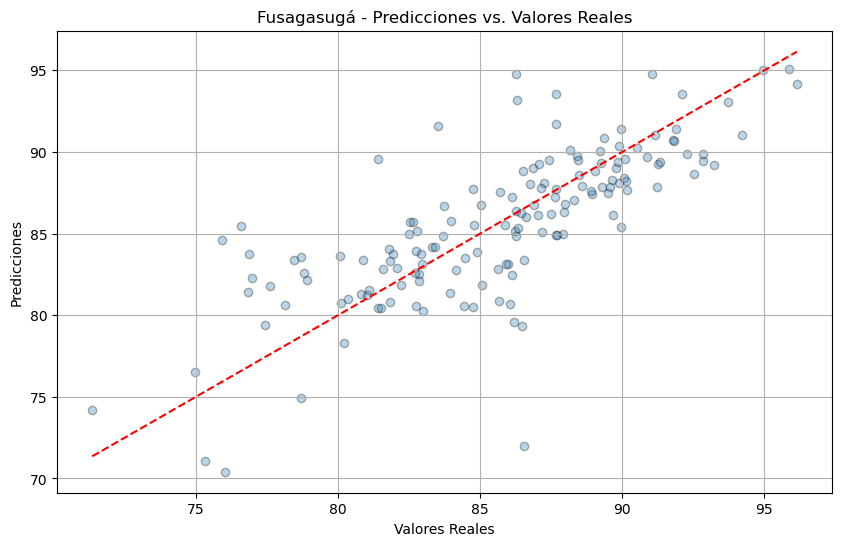

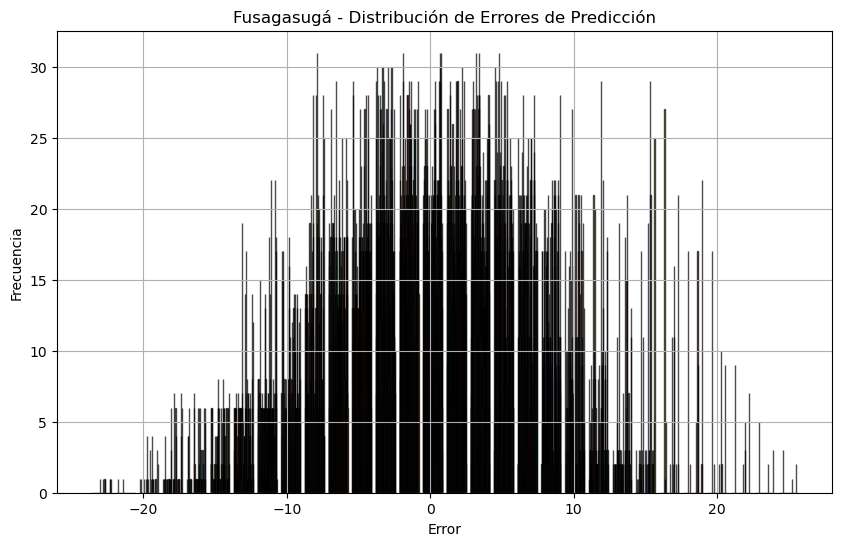

In [22]:
model_f, score_f, y_test_f, y_pred_f = train_evaluate_random_forest(X_fusa, y_fusa)
print(f'Fusagasugá - RandomForestRegression R^2 Score: {score_f:.2f}')
plot_results(y_test_f, y_pred_f, 'Fusagasugá')

#### Entrenar y evaluar modelo RandomForestRegression para Girardot

C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R^2 Score: 0.36
Mean Squared Error: 16.28
Mean Absolute Error: 2.88
Girardot - RandomForestRegression R^2 Score: 0.36


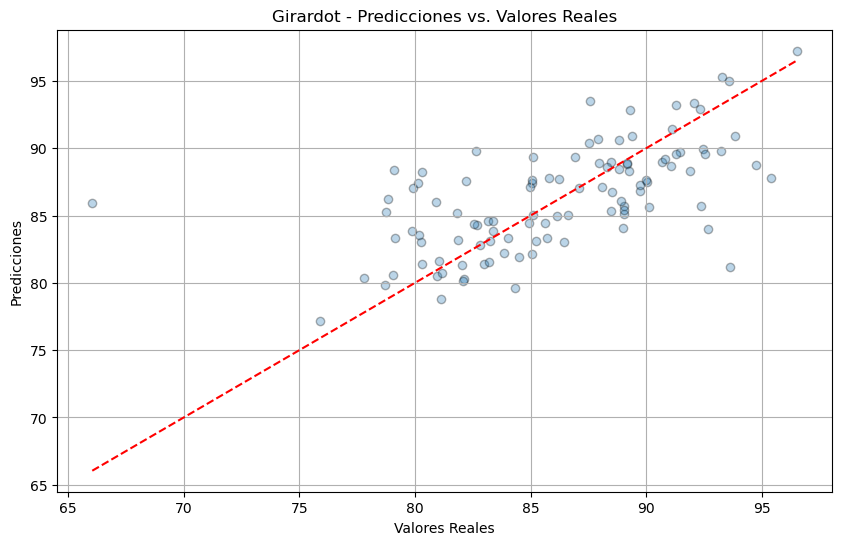

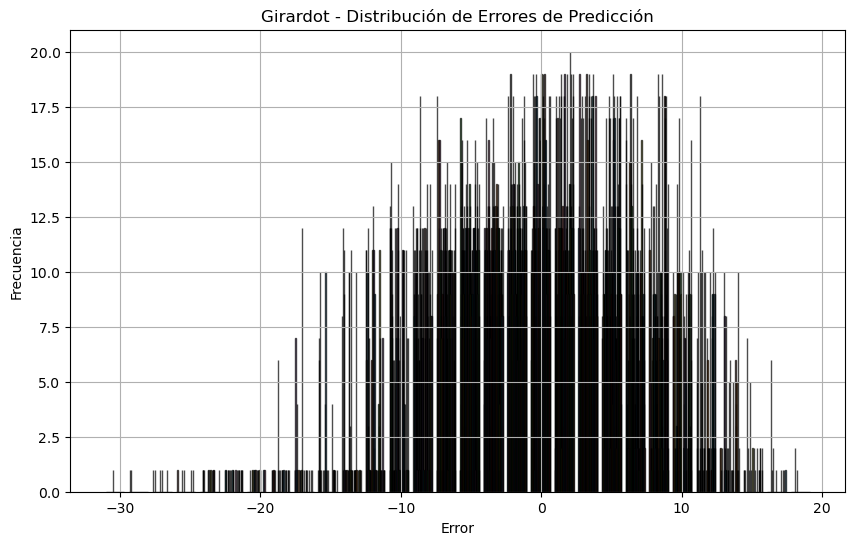

In [23]:
model_g, score_g, y_test_g, y_pred_g = train_evaluate_random_forest(X_girardot, y_girardot)
print(f'Girardot - RandomForestRegression R^2 Score: {score_g:.2f}')
plot_results(y_test_g, y_pred_g, 'Girardot')

In [26]:

def train_evaluate_svr(X, y):
    
    # Definir el preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Intensidad Horaria']),
            ('cat', OneHotEncoder(), ['Grado', 'Asignatura','Periodo','Año'])
        ])
    
    # Crear el pipeline para el modelo SVM
    model_svr = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', SVR())])
    
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo SVM
    model_svr.fit(X_train, y_train)
    
    # Evaluar el modelo
    score = model_svr.score(X_test, y_test)
    
    # Obtener predicciones
    y_pred = model_svr.predict(X_test)
    
    return model_svr, score, y_test, y_pred

#### Entrenar y evaluar modelo SVR para Fusa

Fusagasugá - SVR R^2 Score: 0.53


C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


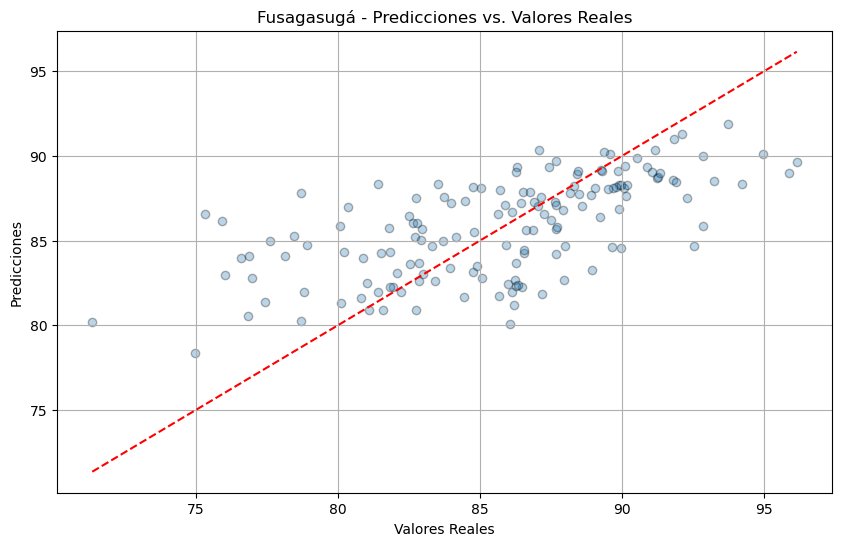

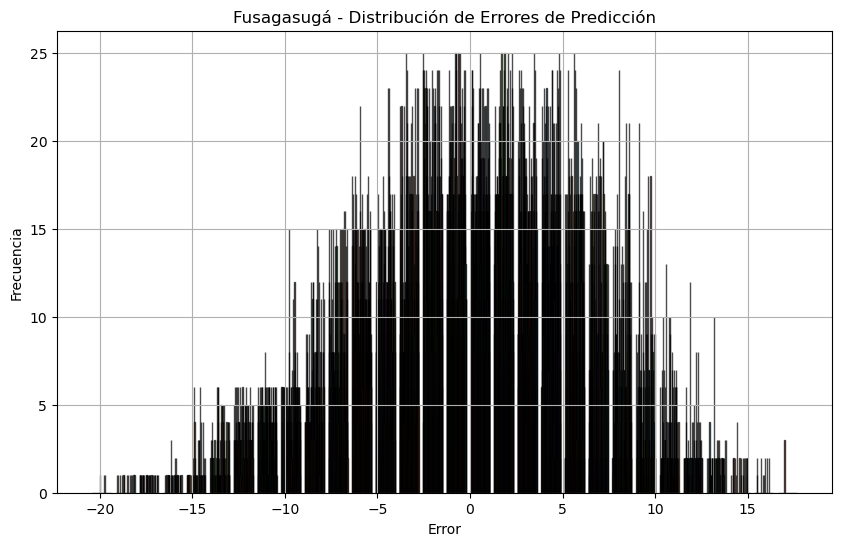

In [28]:
model_f2, score_f2, y_test_f2, y_pred_f2 = train_evaluate_svr(X_fusa, y_fusa)
print(f'Fusagasugá - SVR R^2 Score: {score_f:.2f}')
plot_results(y_test_f2, y_pred_f2, 'Fusagasugá')

#### Entrenar y evaluar modelo SVR para Girardot

C:\Users\Cathe\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Girardot - SVR R^2 Score: 0.36


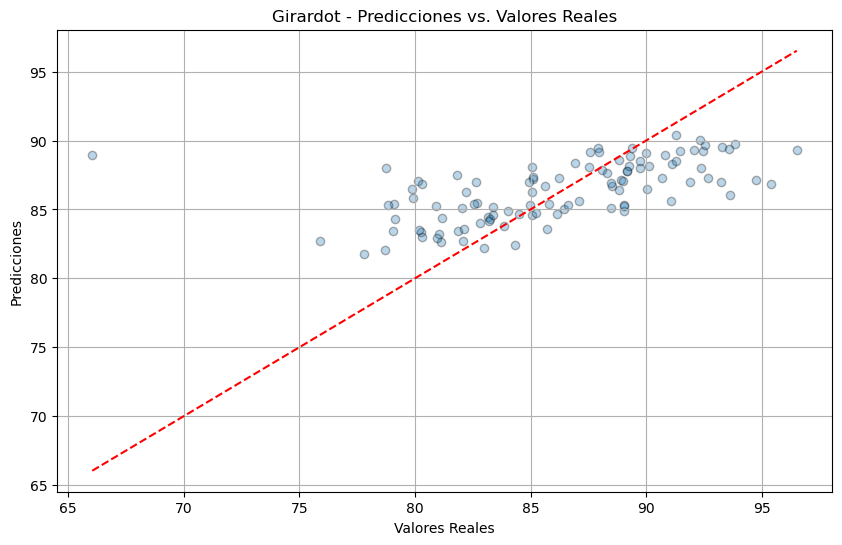

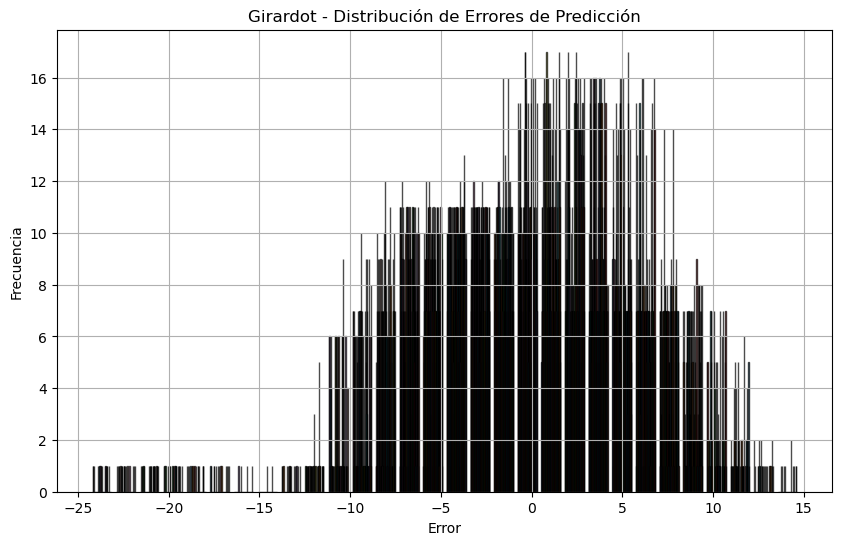

In [29]:
model_g2, score_g2, y_test_g2, y_pred_g2 = train_evaluate_svr(X_girardot, y_girardot)
print(f'Girardot - SVR R^2 Score: {score_g:.2f}')
plot_results(y_test_g2, y_pred_g2, 'Girardot')

## cambiar valor de notas a categoricos
